# LSTM

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Step0：定义LSTM模型类、制作Dataloader

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y
    

class ECGClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(ECGClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # LSTM 输出大小：(batch_size, seq_length, hidden_dim)
        out, (hn, cn) = self.lstm(x)
        # 选择最后一个时间步的输出
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## Step2：定义模型、损失函数、优化器以及训练数据

In [10]:
import numpy as np 

# 检查CUDA是否可用，如果可用则使用CUDA，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 读取数据集
data_train = np.loadtxt('./data/ECG5000_TEST.txt')

# 获取data和label
data, labels = data_train[:, 1:], data_train[:, 0]-1.0 # 这里-1.0是为了将标签从0开始

# 转换成tensor张量
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.long)

# 使用 np.unique 获取所有唯一标签
unique_labels = np.unique(labels)

# 获取唯一标签的数量
num_unique_labels = len(unique_labels)
# print(num_unique_labels)

# Create dataset and dataloader
dataset = CustomDataset(data, labels)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# model = ECGClassifier(input_dim=140, hidden_dim=64, num_layers=4, num_classes=num_unique_labels)
model = ECGClassifier(input_dim=140, hidden_dim=2, num_layers=1, num_classes=num_unique_labels)

model.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using cpu device


## Step3：开始模型训练

In [11]:
# 定义训练过程
def train_model(model, train_loader, criterion, optimizer, num_epochs, device='cpu'):
    for epoch in range(num_epochs):
        for i, (signals, labels) in enumerate(train_loader):
            # 前向传播
            # print(signals.shape)
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
# 开始执行模型训练
train_model(model, train_loader, criterion, optimizer, num_epochs=20, device=device)

Epoch [1/20], Step [100/282], Loss: 1.4540
Epoch [1/20], Step [200/282], Loss: 1.1374
Epoch [2/20], Step [100/282], Loss: 0.6892
Epoch [2/20], Step [200/282], Loss: 0.7991
Epoch [3/20], Step [100/282], Loss: 0.5130
Epoch [3/20], Step [200/282], Loss: 0.3900
Epoch [4/20], Step [100/282], Loss: 0.5566
Epoch [4/20], Step [200/282], Loss: 0.2713
Epoch [5/20], Step [100/282], Loss: 0.2366
Epoch [5/20], Step [200/282], Loss: 0.2057
Epoch [6/20], Step [100/282], Loss: 0.3405
Epoch [6/20], Step [200/282], Loss: 0.1627
Epoch [7/20], Step [100/282], Loss: 0.4669
Epoch [7/20], Step [200/282], Loss: 0.2608
Epoch [8/20], Step [100/282], Loss: 0.4884
Epoch [8/20], Step [200/282], Loss: 0.1274
Epoch [9/20], Step [100/282], Loss: 0.2980
Epoch [9/20], Step [200/282], Loss: 0.4142
Epoch [10/20], Step [100/282], Loss: 0.0946
Epoch [10/20], Step [200/282], Loss: 0.2436
Epoch [11/20], Step [100/282], Loss: 0.3768
Epoch [11/20], Step [200/282], Loss: 0.2229
Epoch [12/20], Step [100/282], Loss: 0.0967
Epoch 

## Step4：测试集验证

In [12]:
## Step4：测试集验证
# 读取测试数据集
data_test = np.loadtxt('./data/ECG5000_TEST.txt')

# 获取data和label
test_data, test_labels = data_train[:, 1:], data_train[:, 0]-1.0
test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.long)

test_dataset = CustomDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

correct = 0
total = 0
total_loss = 0.0

y_pred = []
y_true = []

with torch.no_grad():  # 关闭梯度计算
    for data, labels in test_loader:
        if device.type == 'cuda':
            data, labels = data.to(device), labels.to(device)  # Move data and labels to the device
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)  # 计算损失
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_pred.extend(predicted.cpu().numpy())  # 收集预测结果
        y_true.extend(labels.cpu().numpy())     # 收集真实标签

average_loss = total_loss / len(test_loader)
accuracy = correct / total
print(f'Accuracy of the model on the test data: {100 * accuracy}%')
print(f'Average loss: {average_loss}')

Accuracy of the model on the test data: 93.22222222222221%
Average loss: 0.22772417819955282


## Step5: 绘制confusion matrix


/var/folders/3s/08ljmbzn5sq3s0j06xf02qbm0000gn/T/ipykernel_62974/3463582496.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(np.unique(y_pred)))
/var/folders/3s/08ljmbzn5sq3s0j06xf02qbm0000gn/T/ipykernel_62974/3463582496.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(np.unique(y_pred)))


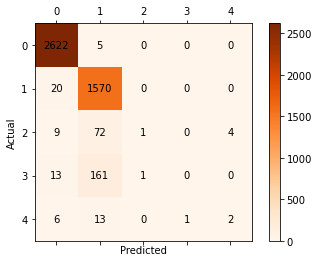

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

# 使用matplotlib绘制混淆矩阵
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Oranges)  # 选择颜色映射

# 为图添加颜色条
plt.colorbar(cax)

# 设置坐标轴
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels([''] + list(np.unique(y_pred)))
ax.set_yticklabels([''] + list(np.unique(y_pred)))

# 在混淆矩阵的各个单元格中添加数值标签
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

# 显示图表
plt.show()

## 打印模型结构、参数

In [14]:
for name, layer in model.named_children():
    print(f"Layer: {name}")
    print(f"Structure: {layer}")
    if hasattr(layer, 'activation'):
        print(f"Activation Function: {layer.activation}")
    print()
    
lstm_params = list(model.lstm.named_parameters())
for name, param in lstm_params:
    print(f"{name}: {param.size()}")
    
print(" \n--------------------------------\n")
  
total_params = 0
for name, param in model.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"Layer: {name} | Size: {param.size()} | Number of Parameters: {num_params}")

print(" \n--------------------------------\n")

print(f"模型总参数量: {total_params * 4} Bytes ")

Layer: lstm
Structure: LSTM(140, 2, batch_first=True)

Layer: fc
Structure: Linear(in_features=2, out_features=5, bias=True)

weight_ih_l0: torch.Size([8, 140])
weight_hh_l0: torch.Size([8, 2])
bias_ih_l0: torch.Size([8])
bias_hh_l0: torch.Size([8])
 
--------------------------------

Layer: lstm.weight_ih_l0 | Size: torch.Size([8, 140]) | Number of Parameters: 1120
Layer: lstm.weight_hh_l0 | Size: torch.Size([8, 2]) | Number of Parameters: 16
Layer: lstm.bias_ih_l0 | Size: torch.Size([8]) | Number of Parameters: 8
Layer: lstm.bias_hh_l0 | Size: torch.Size([8]) | Number of Parameters: 8
Layer: fc.weight | Size: torch.Size([5, 2]) | Number of Parameters: 10
Layer: fc.bias | Size: torch.Size([5]) | Number of Parameters: 5
 
--------------------------------

模型总参数量: 4668 Bytes 


## numpy实现LSTM前向推理过程

基于numpy实现推理的流程，很容易实现基于C代码实现LSTM的前向推理。

### LSTM推理公式

\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

In [32]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def lstm_forward_step(input, hx, cx, weights):
    wi, wf, wg, wo = np.split(weights['lstm.weight_ih_l0'], 4)
    bi, bf, bg, bo = np.split(weights['lstm.bias_ih_l0'], 4)
    whi, whf, whg, who = np.split(weights['lstm.weight_hh_l0'], 4)
    bhi, bhf, bhg, bho = np.split(weights['lstm.bias_hh_l0'], 4)
    
    # print(weights['lstm.weight_ih_l0'].shape)
    # print(weights['lstm.bias_ih_l0'].shape)
    # print(weights['lstm.weight_hh_l0'].shape)
    # print(weights['lstm.weight_hh_l0'].shape)
    
    # totol_size = 0
    # totol_size += wi.size + wf.size + wg.size + wo.size
    # totol_size += bi.size + bf.size + bg.size + bo.size
    # totol_size += whi.size + whf.size + whg.size + who.size
    # totol_size += bhi.size + bhf.size + bhg.size + bho.size
    # print(f"总参数量：{totol_size}")

    i = sigmoid(np.dot(input, wi.T) + bi + np.dot(hx, whi.T) + bhi)
    f = sigmoid(np.dot(input, wf.T) + bf + np.dot(hx, whf.T) + bhf)
    g = tanh(np.dot(input, wg.T) + bg + np.dot(hx, whg.T) + bhg)
    o = sigmoid(np.dot(input, wo.T) + bo + np.dot(hx, who.T) + bho)

    # cx = f * cx + i * g  # 此处可以简化，因为在当前案例中，每次输入的cx为zeros矩阵
    cx = i * g
    hx = o * tanh(cx)
    return hx, cx

def fully_connected(x, weights):
    return np.dot(x, weights['fc.weight'].T) + weights['fc.bias']


def model_inference(x, params):
    hidden_size = params['lstm.weight_ih_l0'].shape[0] // 4
    hx = np.zeros((1, hidden_size))
    cx = np.zeros((1, hidden_size))

    # # LSTM 通过每个时间步
    # seq_length = x.shape[1]
    # for t in range(seq_length):
    #     hx, cx = lstm_forward_step(x[:, t, :], hx, cx, params)
    
    hx, cx = lstm_forward_step(x[0, 0, :], hx, cx, params)

    # 应用全连接层
    print(hx)
    
    out = fully_connected(hx, params)
    return out


# 实例化模型
input_size = 140
hidden_size = 16

# 打印模型的权重
for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")
print('--------------------------------------------')

# 将模型权重转换为 NumPy 数组
params = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}

# 初始化隐藏和细胞状态
hx = np.zeros((1, hidden_size))
cx = np.zeros((1, hidden_size))

# 读取测试数据集
data_test = np.loadtxt('./data/ECG5000_TEST.txt')

# 获取data和label
test_data, test_labels = data_test[:, 1:], data_test[:, 0]-1.0

# 随机选择一个测试样本
rd_idx = np.random.randint(test_labels.shape[0])
rd_idx = 100
input_data = test_data[rd_idx,:]

def print_cpp_format(array, array_name="arr"):
    # 将数组元素转换为字符串列表
    elements = map(str, array)
    # 拼接所有元素为一个逗号分隔的字符串
    elements_str = ', '.join(elements)
    # 打印C++风格的数组初始化代码
    print(f"double {array_name}[] = {{{elements_str}}};")

print_cpp_format(input_data)


input_data = input_data.reshape([1,1,140])

# 执行 LSTM 前向传播
output = model_inference(input_data, params)

# 使用原本model进行推理
model.eval()
input_data = torch.tensor(input_data.reshape([1,1,140]), dtype=torch.float32).to(device=device)
output2 = model(input_data)
output2 = output2.detach().cpu().numpy()

# 打印两种推理方式的结果，可以看到是一致的
print(output, '\n' , output2)

# 预测label
predict_ = np.argmax(output)

print(f"预测类型：{predict_}, 真值： {test_labels[rd_idx]}")


lstm.weight_ih_l0: torch.Size([8, 140])
lstm.weight_hh_l0: torch.Size([8, 2])
lstm.bias_ih_l0: torch.Size([8])
lstm.bias_hh_l0: torch.Size([8])
fc.weight: torch.Size([5, 2])
fc.bias: torch.Size([5])
--------------------------------------------
double arr[] = {-0.9653828, -3.4292935, -4.4667261, -4.5022782, -3.8730168, -2.5937239, -1.7200481, -1.5611601, -0.75637187, -0.11362749, -0.17726887, 0.034054011, -0.076005714, -0.26941959, -0.13121241, 0.07436577, -0.19763482, -0.33973715, -0.15893583, -0.24544628, -0.33026761, -0.32636939, -0.058120115, -0.12237561, -0.49445641, -0.38424342, -0.28438239, -0.35577216, -0.49600543, -0.41810702, -0.24830038, -0.36598899, -0.53950957, -0.86199884, -0.71441154, -0.54776947, -0.55518661, -0.37425822, -0.45429818, -0.49918627, -0.52651181, -0.25535826, -0.070875198, -0.12483854, -0.12623492, 0.13251541, -0.057132071, 0.15032902, 0.15771871, -0.12583959, 0.21195017, 0.14869865, 0.047337855, 0.10101258, 0.015139442, 0.15838554, 0.15228459, 0.26926043, 

In [34]:

def save_lstm_parameters(weights, filename):
    # 分割权重和偏置
    wi, wf, wg, wo = np.split(weights['lstm.weight_ih_l0'], 4)
    bi, bf, bg, bo = np.split(weights['lstm.bias_ih_l0'], 4)
    whi, whf, whg, who = np.split(weights['lstm.weight_hh_l0'], 4)
    bhi, bhf, bhg, bho = np.split(weights['lstm.bias_hh_l0'], 4)
    
    # 打开文件进行写入
    with open(filename, 'w') as file:
        # 写入输入门权重和偏置
        file.write("Input Gate Weights (wi):\n")
        file.write(np.array2string(wi) + "\n")
        file.write("Input Gate Bias (bi):\n")
        file.write(np.array2string(bi) + "\n")
        
        # 写入遗忘门权重和偏置
        file.write("Forget Gate Weights (wf):\n")
        file.write(np.array2string(wf) + "\n")
        file.write("Forget Gate Bias (bf):\n")
        file.write(np.array2string(bf) + "\n")
        
        # 写入候选门权重和偏置
        file.write("Candidate Gate Weights (wg):\n")
        file.write(np.array2string(wg) + "\n")
        file.write("Candidate Gate Bias (bg):\n")
        file.write(np.array2string(bg) + "\n")
        
        # 写入输出门权重和偏置
        file.write("Output Gate Weights (wo):\n")
        file.write(np.array2string(wo) + "\n")
        file.write("Output Gate Bias (bo):\n")
        file.write(np.array2string(bo) + "\n")
        
        # 写入隐藏状态权重和偏置
        file.write("Hidden State Weights (whi, whf, whg, who):\n")
        file.write(np.array2string(whi) + "\n")
        file.write(np.array2string(whf) + "\n")
        file.write(np.array2string(whg) + "\n")
        file.write(np.array2string(who) + "\n")
        
        file.write("Hidden State Biases (bhi, bhf, bhg, bho):\n")
        file.write(np.array2string(bhi) + "\n")
        file.write(np.array2string(bhf) + "\n")
        file.write(np.array2string(bhg) + "\n")
        file.write(np.array2string(bho) + "\n")

def save_lstm_parameters_as_cpp(weights, filename):
    # 分割权重和偏置
    wi, wf, wg, wo = np.split(weights['lstm.weight_ih_l0'], 4)
    bi, bf, bg, bo = np.split(weights['lstm.bias_ih_l0'], 4)
    whi, whf, whg, who = np.split(weights['lstm.weight_hh_l0'], 4)
    bhi, bhf, bhg, bho = np.split(weights['lstm.bias_hh_l0'], 4)
    
    fc_w, fc_b = weights['fc.weight'].T, weights['fc.bias']
    
    # 打开文件进行写入
    with open(filename, 'w') as file:
        def write_array(name, array):
            file.write(f"double {name}[] = {{{', '.join(map(str, array.flatten()))}}};\n")
        
        # 写入输入门权重和偏置
        write_array("wi", wi)
        write_array("bi", bi)
        
        # 写入遗忘门权重和偏置
        write_array("wf", wf)
        write_array("bf", bf)
        
        # 写入候选门权重和偏置
        write_array("wg", wg)
        write_array("bg", bg)
        
        # 写入输出门权重和偏置
        write_array("wo", wo)
        write_array("bo", bo)
        
        # 写入隐藏状态权重和偏置
        write_array("whi", whi)
        write_array("whf", whf)
        write_array("whg", whg)
        write_array("who", who)
        
        write_array("bhi", bhi)
        write_array("bhf", bhf)
        write_array("bhg", bhg)
        write_array("bho", bho)
        
        write_array("fc_w", fc_w.T) # 注意此处的转置T
        write_array("fc_b", fc_b)
        
# 将模型权重转换为 NumPy 数组
params = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}

# 保存参数文件
# save_lstm_parameters(params, 'lstm_parameters.txt')

save_lstm_parameters_as_cpp(params, 'lstm_parameters.cpp')
